# Import Libraries

In [47]:
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch

# Crop Image 

In [6]:
def cropImage(inputImage, roi):
    inputImage = cv2.imread(inputImage)
    inputImage = cv2.cvtColor(inputImage, cv2.COLOR_BGR2RGB)
    images = []
    if len(roi) == 0:
        images.append(inputImage)
    else:
        for region in roi:
            x1, y1 = region[0]
            x2, y2 = region[1]
            images.append(inputImage[y1:y2, x1:x2])
    return images

# Localize Text 

In [7]:
def textLocalize(textLocalizer, inputImage):

    ####FILL TEXT LOCALIZER DETECTION CODE HERE#### 
    boxes, extractedText = textLocalizer.detect(inputImage)
    ###############################################
    
    return [boxes, extractedText]

# Separate Dishname and Price

In [9]:
def preProcessing(image):

    ####FILL PREPROCESSING OF TEXT RECOGNITION CODE HERE####
    inputImage = torch.from_numpy(inputImage).float().unsqueeze(0) 
    # For non-batch data
    inputImage = inputImage.unsqueeze(1)
    ########################################################
    
    return inputImage

In [10]:
def initializeModel(savedModelFile="saveModelFile.pth"):
    weightDict = torch.load(savedModelFile, map_location='cpu')['state_dict']
    modifyWeightDict = {}
    for key, value in weightDict.items():
        newKey = key.replace('module.','')
        modifyWeightDict[newKey] = value
    
    net = Model()
    net.load_state_dict(modifyWeightDict, strict=True)

    ####FILL CONVERTER CODE HERE####
    converter = string2SequenceUD(maxLength = 60)
    ################################
    
    return net, converter

In [11]:
def predict(net, converter, inputImage):

    ####FILL TEXT RECOGNITION PREDICTION CODE HERE####
    testPreds = net(inputImage)
    _, predsIdx = testPreds.max(2)
    predsIdx = predsIdx.cpu().numpy() # 193 x batchsize
    predsStr = converter.decodeBatch(predsIdx)
    ##################################################
    
    return predsStr

In [12]:
def categorizeHelper(predsStr):

    hasLetter = False
    hasNumber = False
    numberIndex = []

    word = ""
    for idx in range(len(predsStr)):
        char = thai_digit_to_arabic_digit(predsStr[idx]).replace('-','').replace('.','')
        word += char 

    word = word.strip()   
    for idx, char in enumerate(word):
        char = char.strip()
        if len(char) == 0:
            continue   

        if char == "/":
            continue       

        if char in "0123456789฿":
            hasNumber = True
            numberIndex.append(idx)
        else:
            hasLetter = True

    if hasLetter and hasNumber:
        if numberIndex[0] > (len(word) - 1)//2:
            hasNumber = True
        else:
            hasNumber = False  
    
    isDishName = None

    if hasLetter and hasNumber:
        dishName = word[:numberIndex[0]]
        price = word[numberIndex[0]:]
    elif hasLetter:
        isDishName = True
    elif hasNumber:
        isDishName = False
    else:
        print("ERROR 404")
    
    if isDishName == None:
        output = [dishName, price]
    else:
        output = word

    return isDishName, output

In [13]:
def categorize(boxes, extractedText, net, converter):
    net.eval();
    
    dishName = []
    price = []
    extraPair = []

    for i in range(len(boxes)):
        image = extractedText[i]
        inputImage = preProcessing(image)

        with torch.no_grad():
            predsStr = predict(net, converter, inputImage)
            isDishName, word = categorizeHelper(predsStr)

            if isDishName == None:
                _dishName, _price = word
                extraPair.append([boxes[i].tolist(), [_dishName, _price]])
            elif isDishName:
                dishName.append([boxes[i].tolist(), word])
            else:
                price.append([boxes[i].tolist(), word])

    indexToWordDishName = dict([i, dishName[i][1]] for i in range(len(dishName)))
    indexToWordPrice = dict([i, price[i][1]] for i in range(len(price)))

    return [dishName, price, indexToWordDishName, indexToWordPrice, extraPair]

# Map dishname and it's price

In [15]:
def getReferencePoint(box):
    return box[0]

In [16]:
def getTopRightPoint(box):
    return box[1]

In [17]:
def getPairOfPointsByBox(box):
    firstPoint = getReferencePoint(box)
    secondPoint = getTopRightPoint(box)

    return [firstPoint, secondPoint]

In [18]:
def createLineEquation(pairOfPoints):
    [[x1, y1], [x2, y2]] = pairOfPoints
    # Ax + By + C = 0
    a = y2 - y1
    b = x1 - x2
    c = (-1)*(a*x1 + b*y1)

    return [a, b, c]

In [19]:
import math
def getPerpendicularDistance(lineEquation, point):
    [a, b, c] =  lineEquation
    x, y = point
    d = abs(a*x + b*y + c)/math.sqrt(a**2 + b**2)
    return d

In [21]:
def findEquaFromPoint(point, lineEquation):
    minDistance = math.inf
    bestEquation = None
    for equation in lineEquation:
        distance = getPerpendicularDistance(equation, point)
        if distance < minDistance:
            minDistance = distance
            bestEquation = equation
    return bestEquation

In [22]:
def findPointFromEqua(equation, referencePoint):
    minDistance = math.inf
    bestPoint = None
    for point in referencePoint:
        distance = getPerpendicularDistance(equation, point)
        if distance < minDistance:
            minDistance = distance
            bestPoint = point
    return bestPoint

In [23]:
def findMapping(lineEquation, referencePoint):
    lineEquation = lineEquation.copy()
    referencePoint = referencePoint.copy()

    mapping = []
    if len(lineEquation) <= len(referencePoint):
        pointer = len(lineEquation)
        while len(lineEquation) > 0:
            pointer = (pointer-1+len(lineEquation))%(len(lineEquation))

            equation = lineEquation[pointer]
            guessPoint = findPointFromEqua(equation, referencePoint)
            guessEquation = findEquaFromPoint(guessPoint, lineEquation)

            if equation == guessEquation:
                mapping.append([equation, guessPoint])
                lineEquation.remove(equation)
                referencePoint.remove(guessPoint)
            
    else:
        pointer = len(referencePoint)
        while len(referencePoint) > 0:
            pointer = (pointer-1+len(referencePoint))%(len(referencePoint))

            point = referencePoint[pointer]
            guessEquation = findEquaFromPoint(point, lineEquation)
            guessPoint = findPointFromEqua(guessEquation, referencePoint)

            if point == guessPoint:
                mapping.append([guessEquation, point])
                lineEquation.remove(guessEquation)
                referencePoint.remove(point)           

    return mapping

In [24]:
def getOrder(mapping, lineEquation, referencePoint):
    order = []
    for map in mapping:
        equation = map[0]
        point = map[1]

        equationIdx = lineEquation.index(equation)
        pointIdx = referencePoint.index(point)

        order.append([equationIdx, pointIdx])
    return order

In [25]:
def getMapping(dishName, price):

    pairOfPoints = []
    for name in dishName:
        box = name[0]
        pairOfPoints.append(getPairOfPointsByBox(box))
    
    lineEquation = []
    for pair in pairOfPoints:
        lineEquation.append(createLineEquation(pair))
    
    referencePoint = []
    for p in price:
        box = p[0]
        referencePoint.append(getReferencePoint(box))

    mapping = findMapping(lineEquation, referencePoint)

    order = getOrder(mapping, lineEquation, referencePoint)

    return order

In [26]:
def indexToWord(mapping, indexToWordDishName, indexToWordPrice):
    pairing = []
    for pair in mapping:
        dishName = indexToWordDishName[pair[0]]
        price = indexToWordPrice[pair[1]]
        pairing.append([dishName, price])
    return pairing

In [27]:
def appendExtra(pairing, extraPair):
    _extraPair = [j for [i, j] in extraPair]
    return pairing + _extraPair

# Visualize

In [28]:
def getAllCornerPoint(roi):
    x1, y1 = roi[0]
    x2, y2 = roi[1]

    output = []
    output.append(roi[0])
    output.append([x2, y1])
    output.append(roi[1])
    output.append([x1, y2])

    output = np.asarray(output).astype(np.int)
    return output

In [29]:
def visualize(mapping, dishName, price, extraPair, outputImage, roi):

    if len(roi) == 0:
        additionRoi = np.asarray([0, 0])
    else:
        additionRoi = np.asarray(roi[0])
        cropBox = getAllCornerPoint(roi)
        cv2.polylines(outputImage, [cropBox], True, (255, 69, 0), 4)

    for box in dishName:
        box = np.array(box[0]) + additionRoi
        cv2.polylines(outputImage, [box.astype(np.int)], True, (255, 0, 0), 4) 
    for box in price:
        box = np.array(box[0]) + additionRoi
        cv2.polylines(outputImage, [box.astype(np.int)], True, (0, 0, 255), 4) 
    for box in extraPair:
        box = np.array(box[0]) + additionRoi
        cv2.polylines(outputImage, [box.astype(np.int)], True, (255, 255, 0), 4)

    for map in mapping:
        dishNameIdx = map[0]
        priceIdx = map[1]

        start = tuple(round(i) for i in getTopRightPoint(dishName[dishNameIdx][0]))
        start = tuple(np.asarray(start) + additionRoi)

        end = tuple(round(i) for i in getReferencePoint(price[priceIdx][0]))
        end = tuple(np.asarray(end) + additionRoi)

        cv2.line(outputImage, start, end, (0, 255, 0), 3, cv2.LINE_AA)

    return outputImage

# Main

In [31]:
def main(inputImage, roi=[]):

    print("-- Croping Image --")
    images = cropImage(inputImage, roi)

    print("-- Initialize Localizer --")

    ####FILL TEXT LOCALIZER HERE####
    textLocalizer = dbTextLocalizer(modelFile="model.onnx")
    ################################
    
    print("-- Initialize Recognizer --")
    net, converter = initializeModel()

    output = []
    outputImage = cv2.imread(inputImage)
    outputImage = cv2.cvtColor(outputImage, cv2.COLOR_BGR2RGB)

    for idx, image in enumerate(images):
        print("---------- SubImage {} ----------".format(idx+1))
        print("-- Localizing --")
        boxes, extractedText = textLocalize(textLocalizer, image)

        print("-- Categorizing --")
        dishName, price, indexToWordDishName, indexToWordPrice, extraPair = categorize(boxes, extractedText, net, converter)

        print("-- Mapping --")
        mapping = getMapping(dishName, price)
        pairing = indexToWord(mapping, indexToWordDishName, indexToWordPrice)

        print("-- Append Extra Pair")
        _output = appendExtra(pairing, extraPair)

        print("-- Visualizing --")
        if len(roi) == 0:
            roi = [[]]
        outputImage = visualize(mapping, dishName, price, extraPair, outputImage, roi[idx])

        output += _output
    
    plt.figure(figsize=(10,10))
    plt.imshow(outputImage)
    plt.show()

    return output

In [30]:
inputImage1 = "image/inputImage1.jpg"
inputImage2 = "image/inputImage2.jpg"
inputImage3 = "image/inputImage3.jpg"
inputImage4 = "image/inputImage4.jpg"

-- Croping Image --
-- Initialize Localizer --
-- Initialize Recognizer --
---------- SubImage 1 ----------
-- Localizing --
-- Categorizing --


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


-- Mapping --
-- Append Extra Pair
-- Visualizing --


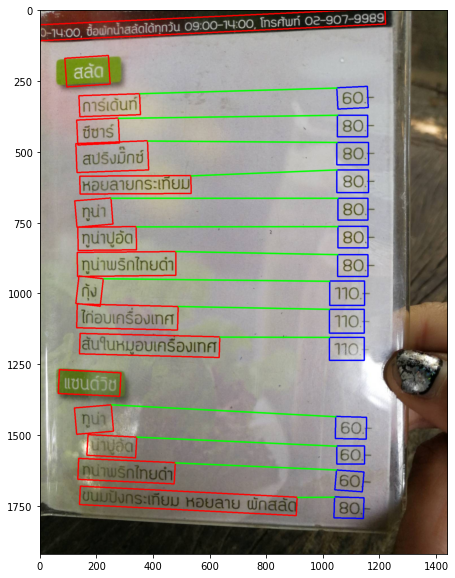

[['การ์เด้นท์', '60'],
 ['ซีซาร์', '80'],
 ['สปริงมี๊กซ์', '80'],
 ['หอยลายกระเทียม', '80'],
 ['ทูน่า', '80'],
 ['ทูน่าปูอัด', '80'],
 ['ทูน่าพริกไทยดำ', '80'],
 ['ไก่อบเครื่องเทศ', '110'],
 ['สันในหมูอบเครื่องเทศ', '110'],
 ['ทูน่า', '60'],
 ['น่าปูอัด', '60'],
 ['ทุน่าพริกไทยดำ', '60'],
 ['ขนมปังกระเทียม หอยลาย ผักสลัด', '80'],
 ['กุ้ง', '110']]

In [32]:
main(inputImage1)

-- Croping Image --
-- Initialize Localizer --
-- Initialize Recognizer --
---------- SubImage 1 ----------
-- Localizing --
-- Categorizing --
-- Mapping --
-- Append Extra Pair
-- Visualizing --


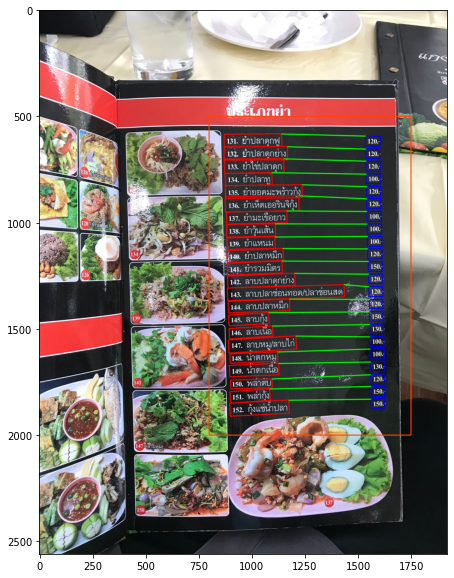

[['131 ยำปลาดุกฟู', '120'],
 ['132 ยำปลาดุกย่าง', '120'],
 ['133 ยำไข่ปลาดุก', '120'],
 ['134 ยำปลาทู', '100'],
 ['135 ยำยอดมะพร้าวกุ้ง', '120'],
 ['136 ยำเห็ดเออรินจิกุ้ง', '120'],
 ['137 ยำมะเขือยาว', '100'],
 ['138 ยำวุ้นเส้น', '100'],
 ['139 ยำแหนม', '100'],
 ['140 ยำปลาหมึก', '120'],
 ['141 ยำรวมมิตร', '150'],
 ['142  ลาบปลาดุกย่าง', '120'],
 ['143 ลาบปลาช่อนทอด ปลาช่อนสด', '120'],
 ['144 ลาบปลาหมึก', '120'],
 ['145 ลาบกุ้ง', '150'],
 ['146 ลาบเนื้อ', '130'],
 ['147 ลาบหมู(ลาบไก่', '100'],
 ['148 น้ำตกหมู', '100'],
 ['149 น้ำตกเนื้อ', '130'],
 ['150 พล่าตับ', '120'],
 ['151 พล่ากุ้ง', '150'],
 ['152 กุ้งแช่น้ำปลา', '150']]

In [38]:
roi = [[[800, 500], [1750, 2000]]]
main(inputImage2, roi)

-- Croping Image --
-- Initialize Localizer --
-- Initialize Recognizer --
---------- SubImage 1 ----------
-- Localizing --
-- Categorizing --
-- Mapping --
-- Append Extra Pair
-- Visualizing --
---------- SubImage 2 ----------
-- Localizing --
-- Categorizing --
-- Mapping --
-- Append Extra Pair
-- Visualizing --
---------- SubImage 3 ----------
-- Localizing --
-- Categorizing --
-- Mapping --
-- Append Extra Pair
-- Visualizing --
---------- SubImage 4 ----------
-- Localizing --
-- Categorizing --
-- Mapping --
-- Append Extra Pair
-- Visualizing --


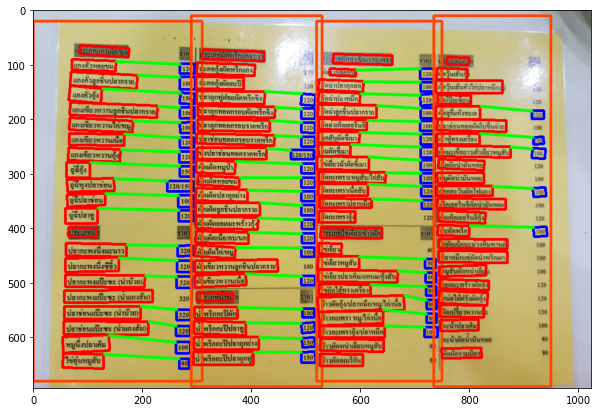

[['แกงคั่วหอยขม', '120'],
 ['แกงคั่วลูกชิ้นปลากราย', '100'],
 ['แกงคั่วกุ้ง', '150'],
 ['แกงเขียวหวานลูกชิ้นปลากราย', '100'],
 ['แกงเขียวหวานไก่หมู', '100'],
 ['แกงเขียวหวานเนื้อ', '120'],
 ['แกงเขียวหวานกุ้ง', '120'],
 ['ฉู่ฉี่กุ้ง', '150'],
 ['ฉู่ฉี่พุงปลาช่อน', '120 150'],
 ['ฉู่ฉี่ปลาช่อน', '100'],
 ['ฉู่ฉี่ปลาทู', '120'],
 ['ปลากะพงนึ่งมะนาว', '320'],
 ['ปลากะพงนึ่งซีอิ้ว', '320'],
 ['ปลากะพงแป๊ะซะ (น้ำบ๊วย)', '320'],
 ['ปลาช่อนแป๊ะซะ(น้ำบ๊วย)', '320'],
 ['ปลาช่อนแป๊ะซะ (น้ำแกงส้ม)', '320'],
 ['หมูนึ่งปลาเค็ม', '100'],
 ['ไข่ตุ๋นหมูสับ', '80'],
 ['ปลาดุกฟูฝอยผัดพริกขิง', '120'],
 ['ปลาดุกทอดกรอบผัดพริกขิง', '120'],
 ['ปลาดุกทอดกรอบราดพริก', '120'],
 ['ปลาช่อนทอดกรอบราดพริก', '120'],
 ['พุงปลาช่อนทอดราดพริก', '120150'],
 ['ผัดเผ็ดหมูป่า', '120'],
 ['ผัดเผ็ดหอยขม', '120'],
 ['ผัดเผ็ดปลาดุกย่าง', '100'],
 ['ผัดเผ็ดลูกชิ้นปลากราย', '100'],
 ['ผัดเผ็ดยอดมะพร้าวกุ้ง', '120'],
 ['ผัดเผ็ดเนื้อ/กบนก', '120'],
 ['ผัดเผ็ดไก่หมู', '100'],
 ['ผัดเขียวหวานเนื้อ', '120'],
 ['น้ำพริกกะปิผัก', '10

In [39]:
roi = [[[0, 20], [310, 680]], [[290, 10], [530, 690]], [[520, 20], [750, 680]], [[735, 10], [950, 690]]]
main(inputImage3, roi)

-- Croping Image --
-- Initialize Localizer --
-- Initialize Recognizer --
---------- SubImage 1 ----------
-- Localizing --
-- Categorizing --
-- Mapping --
-- Append Extra Pair
-- Visualizing --


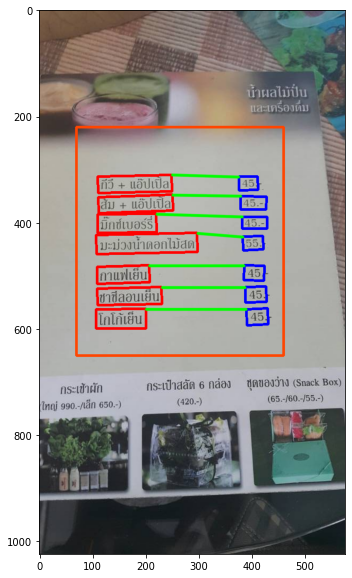

[['กีวี  แอ๊ปเปิ้ล', '45'],
 ['ส้ม  แอ๊ปเปิ้ล', '45'],
 ['มิ๊กซ์เบอร์รี่', '45'],
 ['มะม่วงน้ำดอกไม้สด', '55'],
 ['กาแฟเย็น', '45'],
 ['ชาชีลอนเย็น', '45'],
 ['โกโก้เย็น', '45']]

In [41]:
roi = [[[70, 220], [460, 650]]]
main(inputImage4, roi)